<a href="https://colab.research.google.com/github/mrkevinlin/MLmed/blob/master/MLmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE EVERYTHING**

In [0]:
!pip install --upgrade -q gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
from __future__ import print_function

import math
from google.colab import files
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 15
pd.options.display.float_format = '{:.1f}'.format

# Generate a cleaned up DataFrame of patient data

In [57]:
# Open Google Sheet of patient data and get column titles
patient_dataframe = gc.open('patient_data.csv').sheet1
column_names = patient_dataframe.row_values(1)

# Process Google Sheet into a pandas dataframe of all numeric values
patient_dataframe = pd.DataFrame.from_records(
    patient_dataframe.get_all_values(),
    columns=column_names)
patient_dataframe = patient_dataframe.iloc[1:]
patient_dataframe = patient_dataframe.apply(pd.to_numeric, errors='coerce')
patient_dataframe = patient_dataframe.replace('', np.nan)


# Attempt to clean up dataframe with usable features

# Print the number of valid results in each column
def count_column_results(df):
  for col in df.columns:
    length = (df.dropna(subset=[col]))[col].count()
    print(col + ": %d" %length)
    
# Remove all rows with any empty cells (14 results left)
def clean_up_all(df):
  return df.replace('', np.nan).dropna()

# Calculate missing BMI values from height and weight
def fill_in_bmi(df):
  df['entry_bmi'] = df['entry_bmi'].fillna(703 * df['entry_weight']/(df['entry_height'] ** 2))
  return df

# Remove flagrant outliers by clipping
def remove_outliers(df, feature, maximum):
  df[feature] = df[feature].clip(lower=0, upper=maximum)
  return df

def scale_features_z_score(df, features):
  for col in features:
    df[col] = (df[col] - df[col].mean())/df[col].std()
  return df

# Remove all rows with values missing in the specified columns
def clean_up_by_missing_value_columns(df, column):
  return df.dropna(subset=column)

# Remove any other columns that do not have at least n% the amount of data points as target label
def clean_up_by_target(df, target, n):
  for col in df.columns:
    if (df[col].count() < (df[target].count()*n).iloc[0]):
      df.drop(col, axis=1, inplace=True)
  return df

# Arbitrarily place in zeroes in place of NaNs
def make_up_values(df):
  return df.replace(np.nan,0)

# Specify what feature you want to clean up columns by

# Trial 1: target 6MWT results (meaningless)
#target_feature = ['entry_6mwt']
#selected_features = ['entry_knowledge', 'entry_hads_a', 'entry_hads_d', 'entry_bmi', 'entry_met']

# Trial 2: target METs
target_feature = ['entry_met']
selected_features = ['entry_knowledge', 'entry_hads_a', 'entry_weight', 'entry_bf']

edited_patient_dataframe = patient_dataframe.copy()
edited_patient_dataframe = fill_in_bmi(edited_patient_dataframe)
edited_patient_dataframe = remove_outliers(edited_patient_dataframe, 'entry_6mwt', 2000)
edited_patient_dataframe = clean_up_by_missing_value_columns(edited_patient_dataframe, target_feature)
edited_patient_dataframe = clean_up_by_missing_value_columns(edited_patient_dataframe, selected_features)
edited_patient_dataframe = clean_up_by_target(edited_patient_dataframe, target_feature, 1)
# Scaled by z score
edited_patient_dataframe = scale_features_z_score(edited_patient_dataframe, selected_features)


# Check how many results and columns left in dataframe
count_column_results(edited_patient_dataframe)

# View stats on cleaned up dataframe
edited_patient_dataframe.describe()

year: 240
entry_knowledge: 240
entry_hads_a: 240
entry_weight: 240
entry_waist: 240
entry_bf: 240
entry_met: 240


,year,entry_knowledge,entry_hads_a,entry_weight,entry_waist,entry_bf,entry_met
count,240.0,240.0,240.0,240.0,240.0,240.0,240.0
mean,2015.9,-0.0,0.0,0.0,39.8,-0.0,2.5
std,0.7,1.0,1.0,1.0,6.5,1.0,0.5
min,2015.0,-2.9,-1.5,-2.1,24.0,-2.5,1.1
25%,2015.0,-0.8,-0.7,-0.7,35.4,-0.8,2.2
50%,2016.0,0.3,-0.2,-0.1,39.5,-0.0,2.6
75%,2016.0,0.7,0.6,0.5,43.3,0.9,2.9
max,2017.0,1.7,3.3,3.9,64.5,2.1,4.4


**Assess correlation of features to search for good feature labels**

In [58]:
# Determine correlations between features and target to find best features to use

correlation_dataframe = edited_patient_dataframe.copy()
correlation_dataframe["target"] = edited_patient_dataframe[target_feature]
correlation_dataframe.corr()

,year,entry_knowledge,entry_hads_a,entry_weight,entry_waist,entry_bf,entry_met,target
year,1.0,0.2,0.0,-0.0,0.2,0.1,0.0,0.0
entry_knowledge,0.2,1.0,-0.0,0.1,0.2,0.0,0.3,0.3
entry_hads_a,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0
entry_weight,-0.0,0.1,0.0,1.0,0.8,0.4,0.0,0.0
entry_waist,0.2,0.2,-0.0,0.8,1.0,0.5,-0.0,-0.0
entry_bf,0.1,0.0,0.0,0.4,0.5,1.0,-0.1,-0.1
entry_met,0.0,0.3,-0.0,0.0,-0.0,-0.1,1.0,1.0
target,0.0,0.3,-0.0,0.0,-0.0,-0.1,1.0,1.0


# Randomize and divide the patient DataFrame into training, validation, and test data

In [0]:
# Randomize and divide the data set into training, validation, and test sets
def divide_data(df, train_ratio, validation_ratio, test_ratio):
  train_count, validation_count, test_count = int(len(df)*train_ratio), int(len(df)*validation_ratio), int(len(df)*test_ratio)
  df = df.reindex(np.random.permutation(df.index))
  training_dataframe = df[:train_count]
  validation_dataframe = df[train_count:train_count+validation_count]
  test_dataframe = df[train_count+validation_count:]
  return training_dataframe, validation_dataframe, test_dataframe

# Create dataframe with features for the model, including any synthetic features
def preprocess_features(df, features):
  processed_features = df.copy()
  processed_features = processed_features[features]
  # No synthetic features yet
  return processed_features

# Create dataframe with the target feature
def preprocess_targets(df, targets):
  output_targets = pd.DataFrame()
  output_targets[targets] = df[targets]
  return output_targets


training_data, validation_data, test_data = divide_data(edited_patient_dataframe, .7, .15, .15)

training_examples = preprocess_features(training_data, selected_features)
training_targets = preprocess_targets(training_data, target_feature)

validation_examples = preprocess_features(validation_data, selected_features)
validation_targets = preprocess_targets(validation_data, target_feature)

test_examples = preprocess_features(test_data, selected_features)
test_targets = preprocess_targets(test_data, target_feature)

**Assess appropriateness of data division**

In [60]:
#Do things look ok?

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

Training examples summary:


,entry_knowledge,entry_hads_a,entry_weight,entry_bf
count,168.0,168.0,168.0,168.0
mean,0.0,0.1,-0.0,-0.0
std,1.0,1.0,1.0,1.0
min,-2.9,-1.5,-2.1,-2.5
25%,-0.8,-0.7,-0.7,-0.8
50%,0.3,-0.2,-0.1,-0.1
75%,0.7,0.7,0.3,0.9
max,1.7,3.3,3.9,2.1


Validation examples summary:


,entry_knowledge,entry_hads_a,entry_weight,entry_bf
count,36.0,36.0,36.0,36.0
mean,-0.1,-0.0,0.0,0.1
std,1.0,1.0,1.0,1.0
min,-2.2,-1.5,-1.8,-1.8
25%,-0.8,-0.7,-0.6,-0.6
50%,0.2,-0.2,-0.3,0.1
75%,0.7,0.4,0.8,0.9
max,1.3,2.8,1.9,1.8


Test examples summary:


,entry_knowledge,entry_hads_a,entry_weight,entry_bf
count,36.0,36.0,36.0,36.0
mean,-0.0,-0.3,0.1,-0.0
std,0.9,0.9,1.0,0.9
min,-2.2,-1.5,-1.7,-1.7
25%,-0.8,-1.0,-0.6,-0.8
50%,0.3,-0.4,0.0,0.0
75%,0.7,0.1,0.5,0.6
max,1.3,2.0,2.3,1.4


Training targets summary:


,entry_met
count,168.0
mean,2.5
std,0.5
min,1.1
25%,2.2
50%,2.5
75%,2.9
max,4.4


Validation targets summary:


,entry_met
count,36.0
mean,2.6
std,0.6
min,1.5
25%,2.1
50%,2.7
75%,3.0
max,3.8


Test targets summary:


,entry_met
count,36.0
mean,2.5
std,0.4
min,1.7
25%,2.2
50%,2.4
75%,2.8
max,3.2


# **Set up TensorFlow code**

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[target_feature], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[target_feature], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[target_feature], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

**Train model and tweak hyperparameters**

Training model...
RMSE (on training data):
  period 00 : 0.51
  period 01 : 0.45
  period 02 : 0.44
  period 03 : 0.43
  period 04 : 0.42
  period 05 : 0.41
  period 06 : 0.40
  period 07 : 0.40
  period 08 : 0.39
  period 09 : 0.38
Model training finished.
Final RMSE (on training data):   0.38
Final RMSE (on validation data): 0.55


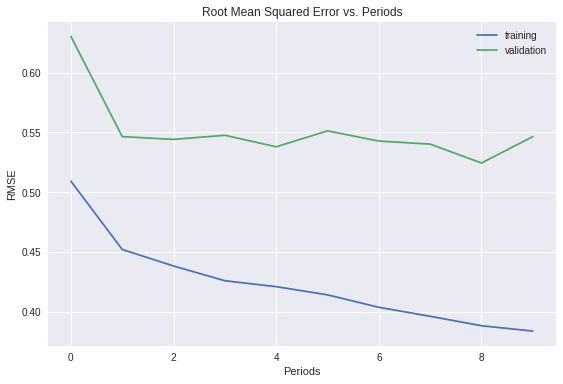

In [62]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=5000,
    batch_size=10,
    hidden_units=[10, 10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

**Assess model performance on test data**

In [63]:
predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets[target_feature], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 0.40
